In [4]:
%pip install -r ./requirements.txt


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
# import statements
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import numpy as np
import powerlaw
import pandas as pd

In [7]:
# %pwd

In [8]:
# Load the graph
with open('src/data/graph/artifact_release_dependency_graph.gpickle', 'rb') as f:
    G = pickle.load(f)
# G = nx.read_gpickle("artifact_release_dependency_graph.gpickle")
print(f"Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Graph loaded: 1397519 nodes, 20934596 edges


# RQ1 & RQ2

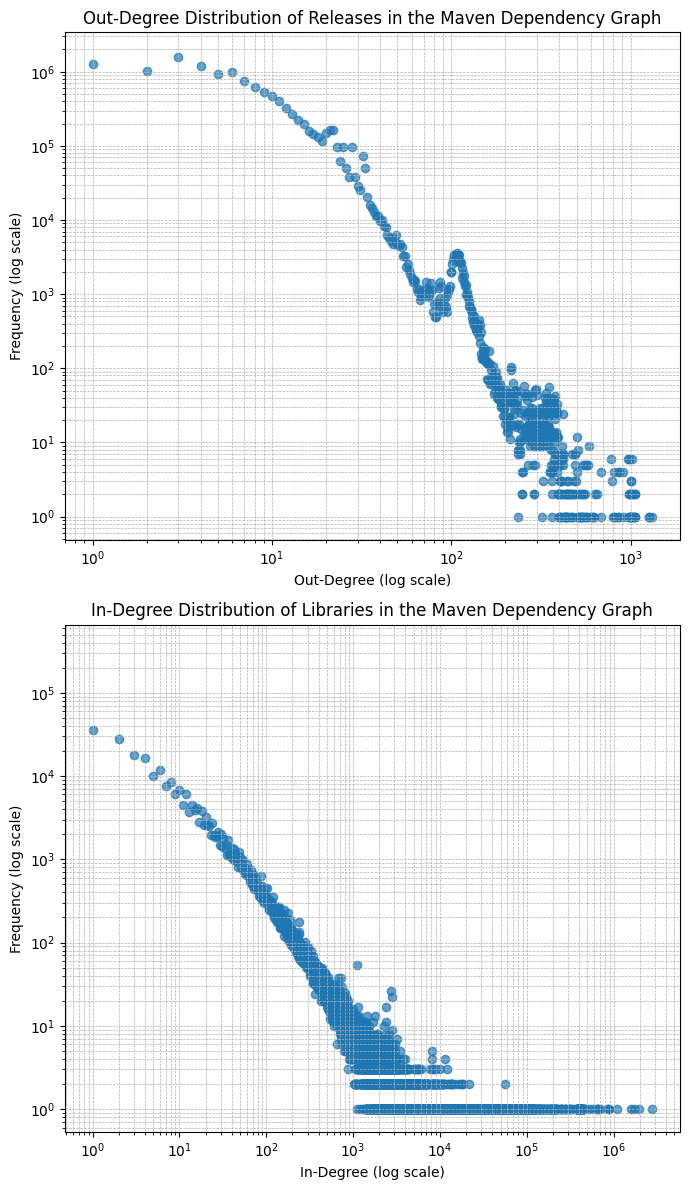

In [9]:
df = pd.read_csv("src/data/csv/out-degree-releases.csv")

# Re-plotting with the updated title
plt.figure(figsize=(7, 12))

# Out-Degree Distribution
plt.subplot(2, 1, 1)
plt.scatter(df['degree'], df['frequency'], alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Out-Degree (log scale)')
plt.ylabel('Frequency (log scale)')
plt.title('Out-Degree Distribution of Releases in the Maven Dependency Graph')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# plt.tight_layout()
# plt.show()

df = pd.read_csv("src/data/csv/in-degree-libraries.csv")


# In-Degree Distribution
plt.subplot(2, 1, 2)
plt.scatter(df['degree'], df['frequency'], alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('In-Degree (log scale)')
plt.ylabel('Frequency (log scale)')
plt.title('In-Degree Distribution of Libraries in the Maven Dependency Graph')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
# plt.savefig("src/fig/degree_distribution-all.png", dpi=600)
plt.show()

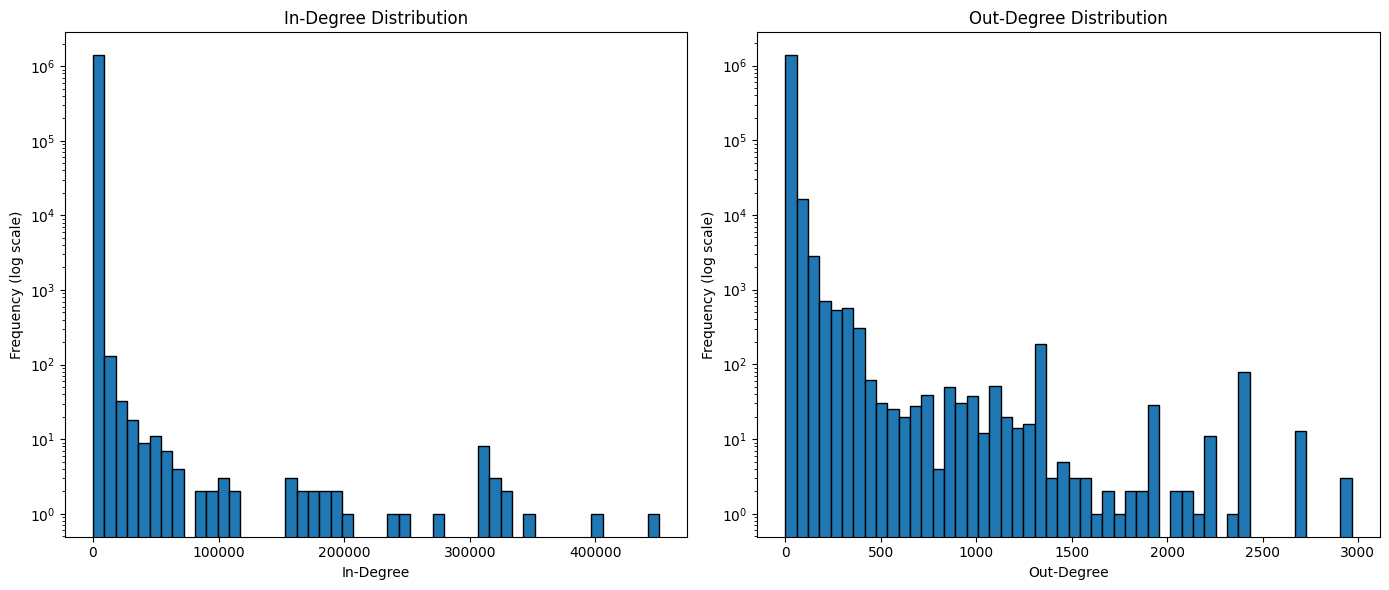

In [10]:

# Get degree sequences
in_degrees = [d for n, d in G.in_degree()]
out_degrees = [d for n, d in G.out_degree()]
total_degrees = [d for n, d in G.degree()]

# Plot histogram of in-degree and out-degree
plt.figure(figsize=(14, 6))

# In-Degree Distribution
plt.subplot(1, 2, 1)
plt.hist(in_degrees, bins=50, edgecolor='black', log=True)
plt.title("In-Degree Distribution")
plt.xlabel("In-Degree")
plt.ylabel("Frequency (log scale)")

# Out-Degree Distribution
plt.subplot(1, 2, 2)
plt.hist(out_degrees, bins=50, edgecolor='black', log=True)
plt.title("Out-Degree Distribution")
plt.xlabel("Out-Degree")
plt.ylabel("Frequency (log scale)")

plt.tight_layout()
# plt.savefig("degree_distributions.png", dpi=600)
plt.show()

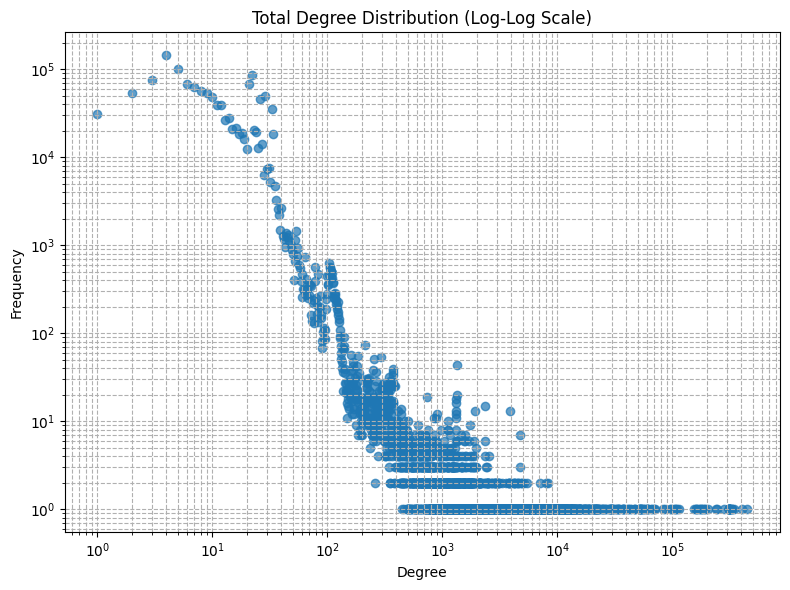

In [11]:
# Total degree counts
degree_counts = np.bincount(total_degrees)
degrees = np.arange(len(degree_counts))
nonzero = degree_counts > 0

plt.figure(figsize=(8, 6))
plt.scatter(degrees[nonzero], degree_counts[nonzero], alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.title("Total Degree Distribution (Log-Log Scale)")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.grid(True, which="both", ls="--")
plt.tight_layout()
# plt.savefig("loglog_degree_distribution.png", dpi=600)
plt.show()

### Degree Distribution with Power-law fit

Calculating best minimal value for power law fit
Power-law alpha (slope): 2.0202
Power-law xmin (cutoff): 3542.0


/Users/evol-lab/.pyenv/versions/3.10.14/lib/python3.10/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in divide
  return likelihoods/norm


Comparison: R = 0.0173, p = 0.2185
Power-law may not be the best fit


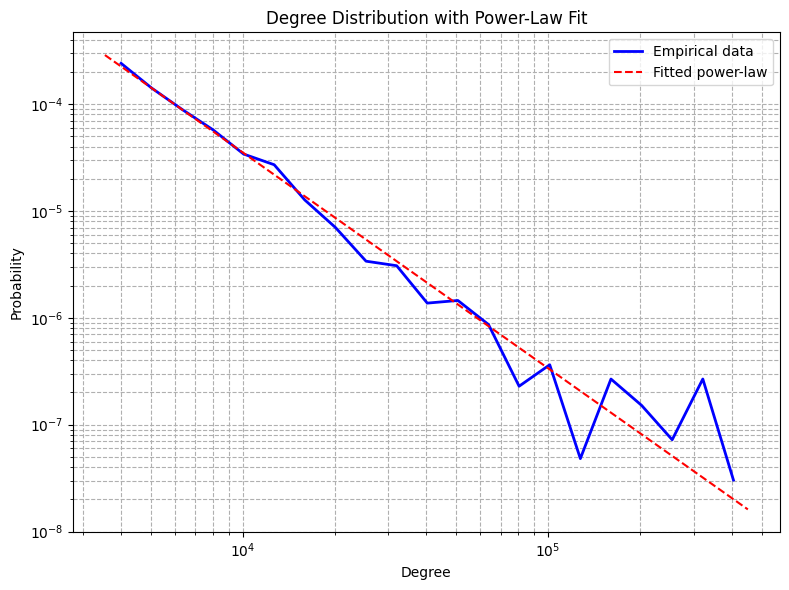

In [12]:
# Get total degree sequence
degree_sequence = [d for n, d in G.degree()]
degree_sequence = [d for d in degree_sequence if d > 0]  # remove zeros (optional)

# Fit the power-law
fit = powerlaw.Fit(degree_sequence, discrete=True)
print(f"Power-law alpha (slope): {fit.power_law.alpha:.4f}")
print(f"Power-law xmin (cutoff): {fit.power_law.xmin}")

# Compare power-law vs. other distributions
R, p = fit.distribution_compare('power_law', 'lognormal')
print(f"Comparison: R = {R:.4f}, p = {p:.4f}")
if R > 0 and p < 0.05:
    print("Power-law is a better fit (significant)")
else:
    print("Power-law may not be the best fit")


# Plot empirical data + fitted power-law
plt.figure(figsize=(8, 6))
fit.plot_pdf(color='b', linewidth=2, label='Empirical data')
fit.power_law.plot_pdf(color='r', linestyle='--', label='Fitted power-law')

plt.title("Degree Distribution with Power-Law Fit")
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
# plt.savefig("fig/powerlaw_fit.png", dpi=300)
plt.show()

# RQ3

In [13]:
# --- PageRank ---
def compute_pagerank(G, weighted=False):
    if weighted:
        pr = nx.pagerank(G, weight='weight')
    else:
        pr = nx.pagerank(G)
    return pr


# PageRank
pr = compute_pagerank(G)
print("Top 10 PageRank nodes:", sorted(pr.items(), key=lambda x: x[1], reverse=True)[:10])

Top 10 PageRank nodes: [('org.apache.felix:org.apache.felix.scr.ds-annotations', 0.004252580121075219), ('org.apache.felix:org.apache.felix.scr.ds-annotations:1.2.8', 0.00412011935686235), ('org.apache.felix:org.apache.felix.scr.ds-annotations:1.2.4', 0.00412011935686235), ('org.apache.felix:org.apache.felix.scr.ds-annotations:1.2.2', 0.00412011935686235), ('org.apache.felix:org.apache.felix.scr.ds-annotations:1.2.0', 0.00412011935686235), ('org.apache.felix:org.apache.felix.scr.ds-annotations:1.2.10', 0.00412011935686235), ('junit:junit', 0.00387534341885265), ('org.hamcrest:hamcrest-all:1.1', 0.0026498363863447405), ('org.hamcrest:hamcrest-all:1.0', 0.0026498363863447405), ('org.hamcrest:hamcrest-all:1.3', 0.0026498363863447405)]


In [15]:
# --- Betweenness Centrality ---
def compute_betweenness_centrality(G, k=None):
    if k:
        bc = nx.betweenness_centrality(G, k=k, seed=42)
    else:
        bc = nx.betweenness_centrality(G)
    return bc

# Betweenness
bc = compute_betweenness_centrality(G, k=100)
print("Top 10 Betweenness nodes:", sorted(bc.items(), key=lambda x: x[1], reverse=True)[:10])

Top 10 Betweenness nodes: [('io.micrometer:micrometer-core', 0.05699607624209949), ('io.projectreactor:reactor-core', 0.050186443393464605), ('org.springframework:spring-core', 0.04543582909359611), ('com.hazelcast:hazelcast', 0.04334858005284269), ('org.mariadb.jdbc:mariadb-java-client', 0.04294372785075985), ('org.testcontainers:mariadb', 0.03963342408180523), ('com.amazonaws:aws-java-sdk', 0.03613263549374706), ('org.apache.logging.log4j:log4j-core', 0.033911986438391765), ('org.assertj:assertj-core', 0.030998929515236955), ('org.testcontainers:testcontainers', 0.025481235117310267)]


In [ ]:
undirected_G = G.to_undirected()

# --- Compute connected components ---
components = list(nx.connected_components(undirected_G))
component_sizes = [len(c) for c in components]
num_components = len(components)
largest_component_size = max(component_sizes)
total_nodes = G.number_of_nodes()

# --- Report stats ---
print(f"Total connected components: {num_components}")
print(f"Largest connected component (LCC) size: {largest_component_size} nodes")
print(f"Total nodes in graph: {total_nodes}")

lcc_percentage = (largest_component_size / total_nodes) * 100
print(f"LCC covers {lcc_percentage:.2f}% of all nodes")

small_components = [size for size in component_sizes if size < largest_component_size]
small_component_percentage = (sum(small_components) / total_nodes) * 100
print(f"Small components cover {small_component_percentage:.2f}% of all nodes")